In [1]:
import sys
print(sys.executable)

/mnt/homeGPU/arodriguez/arodriguez_jupyter/bin/python3.1


In [2]:
!pip install chess
import os
import importlib

import chess
import chess.svg
from jax import random as jrandom
import jax
import jax.nn as jnn
import numpy as np
import matplotlib.pyplot as plt
import shap

os.chdir("/mnt/homeGPU/arodriguez/S-ChessFormer-xai/")
%ls


analisis_partidas/                      LICENSE           run_script_hera.sh
distances_between_pos_embeddings.npy    lichess_bot/      run_script_selene.sh
distances_between_token_embeddings.npy  problemas/        run_script_titan.sh
Dockerfile                              README.md         searchless_chess/
install.sh                              requirements.txt  xai/


In [3]:
%ls searchless_chess/src/

bagz.py               parallel_my_puzzles.py      tokenizer.py
config.py             prueba_jax.py               tournament.py
constants.py          puzzles.py                  training.py
data_loader.py        __pycache__/                training_utils.py
engines/              run_puzzles_hera.sh         train.py
metrics_evaluator.py  run_puzzles_titan.sh        transformer.py
my_puzzles.py         searchless_chess.ipynb      transformer_xai.py
old_my_puzzles.py     testing_dataloader_time.py  utils.py


In [3]:
from searchless_chess.src import transformer_xai, transformer
importlib.reload(transformer_xai)
importlib.reload(shap)
from searchless_chess.src import tokenizer
from searchless_chess.src import training_utils
from searchless_chess.src import utils
from searchless_chess.src.engines import engine
from searchless_chess.src.engines import neural_engines
from searchless_chess.src.engines import engine as engine_lib

#import searchless_chess.src.engines.constants as constants

Failed to import GCSFileSystem; loading of this filesystem will be skipped. Error details: cannot import name 'storage' from 'google.cloud' (unknown location)


In [4]:
# @title Create the predictor (9M)

policy = 'action_value'
num_return_buckets = 128
output_size = num_return_buckets
predictor_config = transformer.TransformerConfig(
    vocab_size=utils.NUM_ACTIONS,
    output_size=output_size,
    pos_encodings=transformer.PositionalEncodings.LEARNED,
    max_sequence_length=tokenizer.SEQUENCE_LENGTH + 2,
    num_heads=8,
    num_layers=8,
    embedding_dim=256,
    apply_post_ln=True,
    apply_qk_layernorm=False,
    use_causal_mask=False,
)

predictor = transformer.build_transformer_predictor(config=predictor_config)

In [6]:
!nvidia-smi

Mon May 19 08:54:29 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:85:00.0 Off |                    0 |
| N/A   31C    P0              45W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# @title Load the predictor parameters
os.chdir("/mnt/homeGPU/arodriguez/S-ChessFormer-xai")
checkpoint_dir = os.path.join(
    os.getcwd(),
    f'searchless_chess/checkpoints/9M',
)
dummy_params = predictor.initial_params(
    rng=jrandom.PRNGKey(6400000),
    targets=np.zeros((1, 1), dtype=np.uint32),
)
params = training_utils.load_parameters(
    checkpoint_dir=checkpoint_dir,
    params=dummy_params,
    use_ema_params=True,
    step=-1,
)

In [6]:
# @title Create the engine
batch_size = 1
#jitted_predict_fn = jax.jit(predictor.predict)

#def fixed_predict_fn(sequences: np.ndarray) -> np.ndarray:
#    """Wrapper around the predictor `predict` function."""
#    assert sequences.shape[0] == batch_size
#    return jitted_predict_fn(
#        params=params,
#        targets=sequences,
#        rng=None,
#    )

#def predict_fn(sequences: np.ndarray) -> np.ndarray:
#    """Wrapper to collate batches of sequences of fixed size."""
#    remainder = -len(sequences) % batch_size
#    padded = np.pad(sequences, ((0, remainder), (0, 0)))
#    sequences_split = np.split(padded, len(padded) // batch_size)
#    all_outputs = []
#    for sub_sequences in sequences_split:
#        all_outputs.append(fixed_predict_fn(sub_sequences))
#    return all_outputs #outputs[: len(sequences)]  # Crop the padded sequences.



predict_fn = neural_engines.wrap_predict_fn(predictor, params, batch_size=batch_size)

In [7]:
_, return_buckets_values = utils.get_uniform_buckets_edges_values(
    num_return_buckets
)

engine_9M = neural_engines.ENGINE_FROM_POLICY[policy](
    return_buckets_values=return_buckets_values,
    predict_fn=predict_fn,
    temperature=0.005,
)

- Visualizar capas de atención 
- Heatmaps sobre el tablero
- Integrated Gradients
- SHAP
- Probing

# SHAP

In [8]:
boards = [chess.Board("r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1")]     # Tablero de ejemplo, lo suyo sería la lista de tableros que queramos analizar


In [10]:
def get_sequences_from_board(board: chess.Board) -> np.ndarray:
    """Get the sequences from a chess board."""
    results = engine_9M.analyse(board)

    # Probs dadas en logaritmo. Hemos de deshacer el cambio
    buckets_log_probs = results["log_probs"]
    win_probs = np.inner(np.exp(buckets_log_probs), engine_9M._return_buckets_values)
    sorted_legal_moves = engine_lib.get_ordered_legal_moves(board)
    
    # Obtenemos el índice del movimiento que se va a jugar, que es el que mayor probabilidad tiene
    i = max(enumerate(win_probs), key=lambda x: x[1])[0]

    #print('sorted_legal_moves:', sorted_legal_moves)
    legal_actions = [utils.MOVE_TO_ACTION[x.uci()] for x in sorted_legal_moves]
    #print('legal_actions 1:', legal_actions)
    legal_actions = np.array(legal_actions, dtype=np.int32)
    #print('legal_actions 2:', legal_actions)
    legal_actions = np.expand_dims(legal_actions, axis=-1)
    #print('legal_actions 3:', legal_actions)
    #print('legal_actions.shape:', legal_actions.shape)
    # Tokenize the return buckets.
    dummy_return_buckets = np.zeros((len(legal_actions), 1), dtype=np.int32)
    #print('dummy_return_buckets:', dummy_return_buckets)
    #print('dummy_return_buckets.shape:', dummy_return_buckets.shape)
    # Tokenize the board.
    tokenized_fen = tokenizer.tokenize(board.fen()).astype(np.int32)
    #print('tokenized_fen:', tokenized_fen)
    #print('tokenized_fen.shape:', tokenized_fen.shape)
    sequences = np.stack([tokenized_fen] * len(legal_actions))
    #print('sequences:', sequences)
    #print('sequences.shape:', sequences.shape)
    # Create the sequences.
    sequences = np.concatenate(
        [sequences, legal_actions, dummy_return_buckets],
        axis=1,
    )
    return sequences

In [11]:
pos_labels = ['<turn>',
            'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8',
            'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7',
            'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6',
            'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5',
            'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4',
            'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3',
            'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2',
            'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1',
            '<castling_1>', '<castling_2>', '<castling_3>', 'castling_4>',
            '<en_passant_letter>','<en_passant_number>',
            '<halfmove_1>', '<halfmove_2>', '<halfmove_3>',
            '<fullmove_1>', '<fullmove_2>', '<fullmove_3>', 
            'move', 'padding']

In [29]:
print(len(pos_labels))

79


In [12]:
def predict_fn_shap_2(input_array):
    """
    input_array: np.array of shape (n_samples, 79)
    returns: np.array of shape (n_samples, 1)
    """

    results = predict_fn(input_array)
    log_probs = results[:, -1]

    # Probs dadas en logaritmo. Hemos de deshacer el cambio
    
    win_probs = np.inner(np.exp(log_probs), engine_9M._return_buckets_values)
    print('win_probs:', win_probs)
    return win_probs

In [13]:
import pandas as pd

board = chess.Board("r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1")
move = "c7c6"

tokenized_board = get_sequences_from_board(board)
df = pd.DataFrame(tokenized_board, columns=pos_labels)

#print(predict_fn_shap_2(df.to_numpy()))

init_board = chess.Board()
background = np.array([[11, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  0,
 30, 30,  1, 30, 30, 24,  0]])

print(background.shape)

explainer = shap.KernelExplainer(predict_fn_shap_2, background, algorithm="partition")  # o kernel
shap_values = explainer(tokenized_board[0].reshape(1, -1))

(1, 79)
win_probs: [0.49624793]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.09752802]
win_probs: [0.51810145 0.06731513 0.5168675  ... 0.13423137 0.11263635 0.06211373]


cohort_exps [.values =
array([0.        , 0.14150175, 0.        , 0.09426337, 0.16181956,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07332811, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.21996286,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.494716  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05723266, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09543555, 0.        , 0.22196006, 0.        , 0.        ,
       0.        , 0.        , 0.22025131, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.      

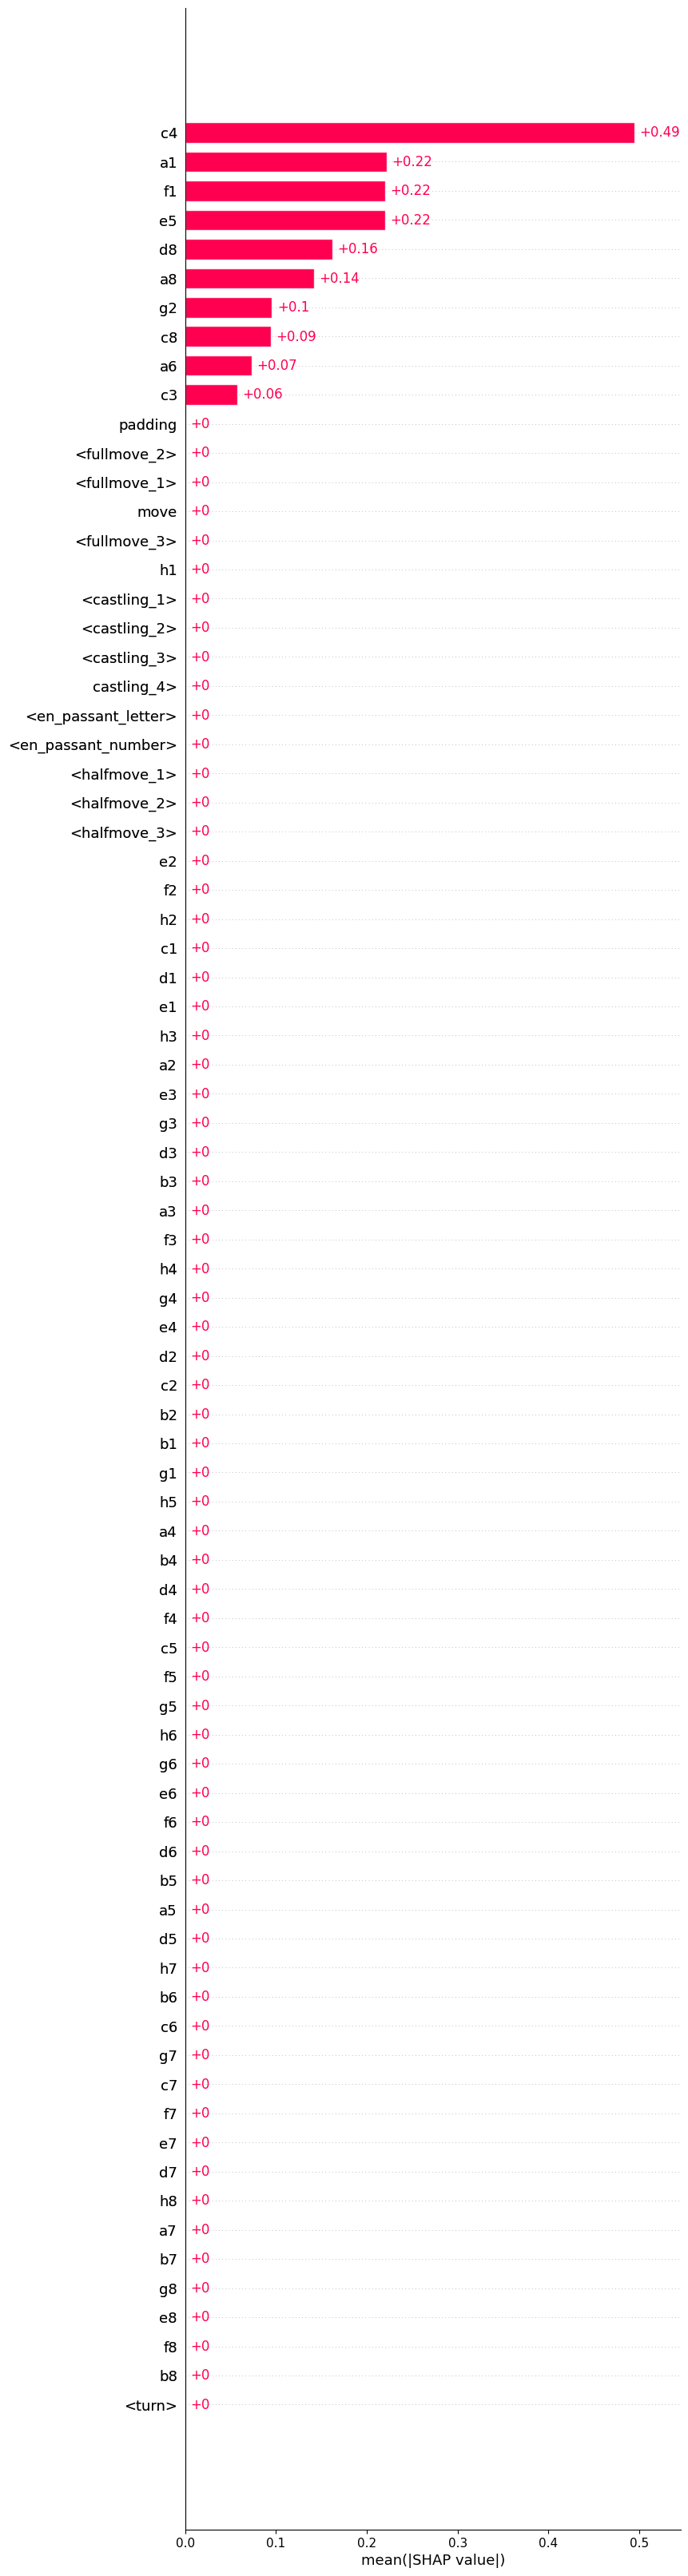

In [86]:
shap_values.feature_names = pos_labels
shap.plots.bar(shap_values, max_display=None)

In [ ]:
def apply_shap_to_fen(fen :str, move:str):
    """
    Apply SHAP to a FEN string.
    fen: str
    returns: shap_values: np.array of shape (n_samples, 1)
    """
    board = chess.Board(fen)
    legal_moves = engine_lib.get_ordered_legal_moves(board)
    move_index = np.where([move == x.uci() for x in legal_moves])[0][0]
    print('move_index:', move_index)
    tokenized_board = get_sequences_from_board(board)
    background = [11, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  0,
 30, 30,  1, 30, 30, 24,  0]

    explainer = shap.Explainer(predict_fn_shap_2, background, algorithm="partition")  # o kernel
    shap_values = explainer(tokenized_board[move_index]) #.reshape(1, -1))
    return shap_values

In [ ]:
shap_values_2 = apply_shap_to_fen("k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1")

In [82]:
board = chess.Board("k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1")
engine_lib.get_ordered_legal_moves(board)
print(get_sequences_from_board(board)[3])

[ 29  21  30  30  30  30  30  30  30  30  30  30  30  30  30  11  30  30
  30  30  30  30  22  30  30  30  30  30  30  30  30  30  30  30  30  30
  30  30  30  30  30  30  30  30  30  27  30  30  30  30  30  30  30  30
  24  30  30  30  28  30  30  30  30  30  30  30  30  30  30  30  30   0
  30  30   1  30  30 332   0]


cohort_exps [.values =
array([7.28319311e-03, 2.24486249e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 2.24486249e-03, 7.28319311e-03, 2.24486249e-03,
       7.28319311e-03, 7.28319311e-03, 7.28319311e-03, 2.24486249e-03,
       2.24486249e-03, 7.28319311e-03, 6.63558547e-02, 7.28319311e-03,
       4.66145135e-02, 7.28319311e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 7.28319311e-03, 1.75102314e-01, 7.28319311e-03,
       0.00000000e+00, 1.69848161e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 7.28319311e-03, 1.56722826e-03, 2.24486249e-03,
       2.24486249e-03, 7.28319311e-03, 7.28319311e-03, 2.24486249e-03,
       7.28319311e-03, 7.28319311e-03, 1.38598566e-03, 7.28319311e-03,
       7.28319311e-03, 7.28319311e-03, 4.62009243e-06, 7.28319311e-03,
       3.19391390e-04, 7.28319311e-03, 7.28319311e-03, 7.28319311e-03,
       1.56722826e-03, 2.24486249e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 2.24486249e-03, 2.79928605e-02,

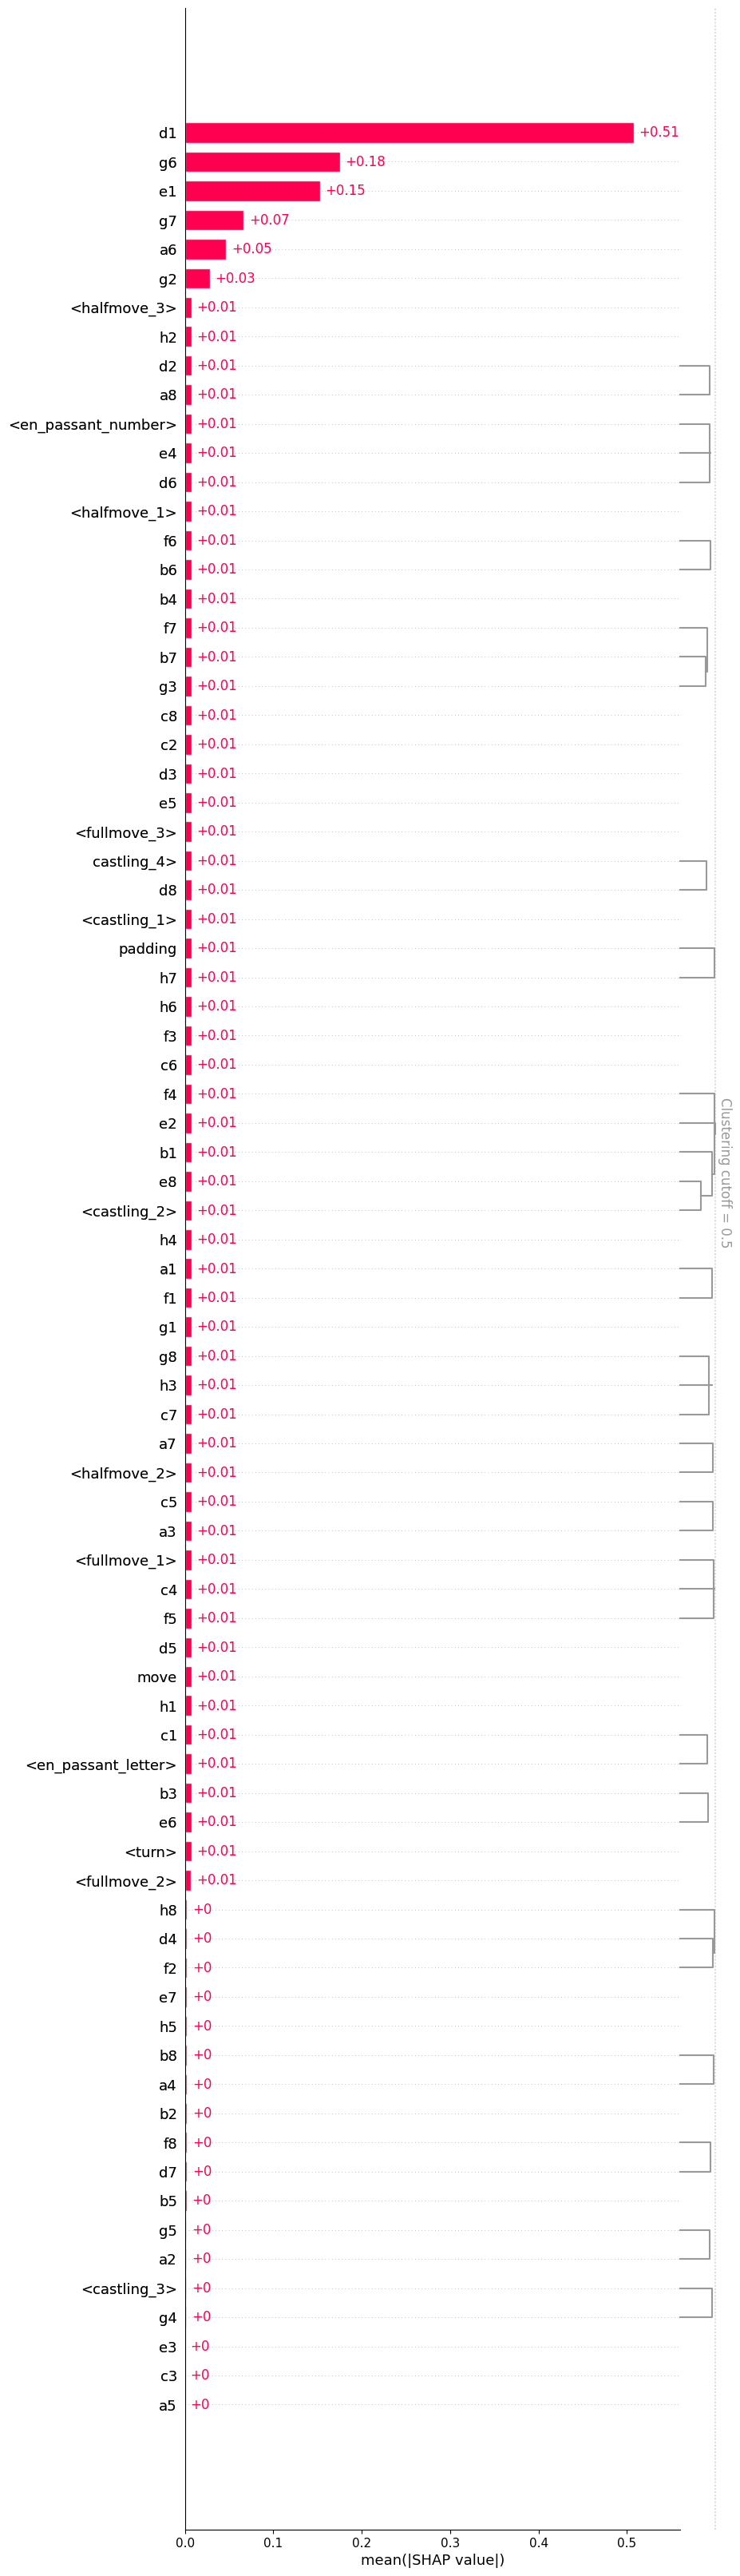

In [75]:
shap.plots.bar(shap_values_2, max_display=None)

In [72]:
shap_values_2 = apply_shap_to_fen("k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1")
shap_values_2.feature_names = pos_labels
shap.plots.bar(shap_values_2, max_display=None)

win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889]
win_probs: [0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261]
win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261]
win_probs: [0.02185368 0.02789926 0.02879855 0.0196428  0.02983801 0.

  0%|          | 0/498 [00:00<?, ?it/s]

win_probs: [0.44322996 0.50782314 0.52034395 0.43696279 0.48815979 0.4715061
 0.48317798 0.45502349 0.49296944 0.51653266 0.48329412 0.52370183
 0.50974058 0.52963037 0.43159682 0.46878992 0.49502977 0.41077338
 0.47978957 0.46867866 0.02225794 0.02899316 0.03157554 0.01982345
 0.04086764 0.05074961 0.01366769 0.01280253 0.03808489 0.08635783
 0.06391272 0.08729022 0.05460229 0.07259213 0.02016911 0.02152626
 0.20691559 0.01947005 0.0377832  0.04861835 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728
 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376
 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376
 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376
 0.97629376 0.97629376 0.21477728 0.21477728 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477

PartitionExplainer explainer:   3%| | 1/30 [00:00<?, ?it/s]

win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889]
win_probs: [0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908]
win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908]
win_probs: [0.02185368 0.02789926 0.02879855 0.0196428  0.02983801 0.

  0%|          | 0/498 [00:00<?, ?it/s]

win_probs: [0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.0039425  0.0039425  0.0039425  0.0039425
 0.0039425  0.0039425  0.0039425  0.0039425  0.00394

PartitionExplainer explainer:   7%| | 2/30 [07:36<3:33:06, 


KeyboardInterrupt: 

In [36]:
print(df.shape)

(47, 79)


In [22]:
shap_values.values

array([[[-0.04635842],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

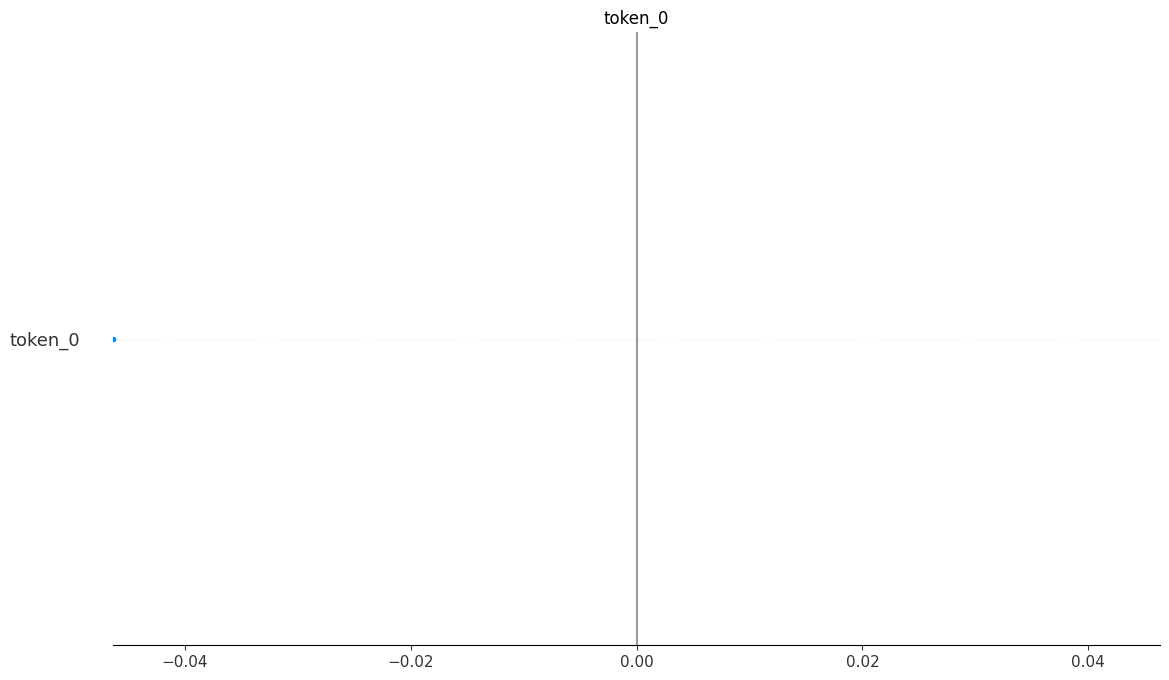

In [18]:
sequence_reshaped = sequence.reshape(1, -1)
shap_values = explainer(sequence_reshaped)

# Forzar nombres de características
shap_values.feature_names = [f"token_{i}" for i in range(sequence_reshaped.shape[1])]

# Asignar datos como matriz 2D (no uses [0])
shap_values.data = sequence_reshaped.astype(np.float32)

# Summary plot
shap.summary_plot(
    shap_values.values,
    shap_values.data,
    feature_names=shap_values.feature_names,
    plot_type="bar",  # o "dot"
    show=True
)


In [15]:
print(shap_values)

.values =
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
  

In [14]:
# @title Compute the win percentages for all legal moves

board = chess.Board("r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1")
results = engine_9M.analyse(board)
print(results)
buckets_log_probs = results['log_probs']

# Compute the expected return.
win_probs = np.inner(np.exp(buckets_log_probs), return_buckets_values)
sorted_legal_moves = engine.get_ordered_legal_moves(board)

print(board.fen())
print(f'Win percentages:')
for i in np.argsort(win_probs)[::-1]:
  print(f'  {sorted_legal_moves[i].uci()} -> {100*win_probs[i]:.1f}%')

{'log_probs': array([[-14.456982 , -17.918943 , -17.833376 , ..., -19.492619 ,
        -19.647696 , -17.849249 ],
       [-13.880351 , -15.478263 , -15.105826 , ..., -18.719418 ,
        -18.434452 , -16.80056  ],
       [-13.903162 , -15.8539505, -15.258402 , ..., -15.260092 ,
        -15.692844 , -14.4004135],
       ...,
       [-16.072968 , -17.287943 , -16.847778 , ..., -16.858864 ,
        -16.975084 , -16.52268  ],
       [-16.309505 , -17.30768  , -16.871548 , ..., -16.777864 ,
        -16.91726  , -16.426367 ],
       [-14.061224 , -15.891546 , -15.576529 , ..., -16.08771  ,
        -16.16223  , -15.486992 ]], shape=(47, 128), dtype=float32), 'fen': 'r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1'}
r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1
Win percentages:
  c7c6 -> 57.5%
  c8e6 -> 56.5%
  c8g4 -> 52.5%
  d8d4 -> 52.3%
  e5c5 -> 52.2%
  a6b4 -> 52.1%
  g8g7 -> 52.1%
  c8d7 -> 51.9%
  a8b8 -> 51.5%
  d8d2 -> 51.0%
  h7h5 -> 50.9%
  h7h6 -> 49.

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------